In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# AI Quick Build Experience Backend

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/ai_quick_build_experience_backend.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fuse-cases%2Feducation%2Fai_quick_build_experience_backend.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/education/ai_quick_build_experience_backend.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/education/ai_quick_build_experience_backend.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Zack Akil](https://github.com/zackail)|

## Overview

The AI Quick Build experience is a Gemini and Imagen powered game show experience where contestants race against the clock to construct the best interpretation of a given object, e.g., a "lighthouse." Gemini provides live commentary and performs the final judging of whose build is the best. Then, Imagen takes what has been built and brings it to life.

 This notebook provides an insight into how the AI Quick Build experience was built and how you can build similar features into your applications.

The notebook is divided into three main sections:

1. **Real-time commentary:** This section demonstrates how to generate live commentary using Gemini Flash and the Cloud Text-to-Speech API.
2. **Judging:** This section showcases how to use Gemini Pro for in-depth analysis and judgment of the builds, providing detailed reasoning and a winner announcement script.
3. **Image generation:** This section explores how to enhance the winner's creation by generating a dynamic background using Imagen, and then creating an animated GIF that transitions between the original and generated images.

### Objective

This notebook aims to:

* Provide a clear understanding of how the AI Quick Build experience was developed.
* Enable users to build similar experiences by demonstrating the capabilities of Gemini and Imagen.
* Inspire users to explore new applications of these technologies in areas like education and entertainment.

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI
- Cloud Text-to-Speech

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Text-to-Speech pricing](https://cloud.google.com/text-to-speech/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Get Started

### Install Vertex AI SDK and other required packages

In [ ]:
%pip install --upgrade --quiet google-cloud-texttospeech \
                        google-cloud-aiplatform

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [1]:
PROJECT_ID = "YOUR PROJECT ID"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user(project_id=PROJECT_ID)

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [2]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

# Part 1: Real-Time Commentary

This section demonstrates how to use Gemini Flash and the Cloud Text-to-Speech API to generate real-time commentary on the builds as they are being constructed.

Gemini Flash's low latency allows us to provide immediate feedback and analysis, enhancing the interactive nature of the experience.

We will also showcase the power of using Google Cloud's new Casual voices for text-to-speech, which can create a more natural and engaging commentary experience.

### Setting up the Commentator's Voice

Here we define a helper function that utilizes the Cloud Text-to-Speech API to generate speech from a given text script. We will use this function to give our commentator a voice.

In [ ]:
import json

import IPython
from IPython import display
from google.cloud import texttospeech

texttospeech_client = texttospeech.TextToSpeechClient()


def speak(script: str, voice_name: str = "en-US-Casual-K") -> IPython.lib.display.Audio:
    """
    Generates speech from the given script using the specified voice and plays it.

    Args:
        script: The text script to convert to speech.
        voice_name: The name of the voice to use (default: 'en-US-Casual-K').
    """
    generate_speech(script, voice_name)
    return display.Audio("output.wav")


def generate_speech(
    script: str,
    voice_name: str = "en-US-Casual-K",
    output_file_name: str = "output.wav",
) -> str:
    """Generates a wav audio file from the given script using Google Cloud Text-to-Speech.

    Args:
        script: The text script to convert to speech.
        voice_name: The name of the voice to use (e.g., 'en-US-Casual-K').
        output_file_name: The name of the output MP3 file.
    """
    synthesis_input = texttospeech.SynthesisInput(text=script)

    language_code = extract_language_code(voice_name)

    voice = texttospeech.VoiceSelectionParams(
        language_code=language_code, name=voice_name
    )

    # Select the type of audio file you want returned
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.LINEAR16
    )

    # Perform the text-to-speech request on the text input with the selected
    tts_response = texttospeech_client.synthesize_speech(
        input=synthesis_input, voice=voice, audio_config=audio_config
    )

    # The response's audio_content is binary.
    with open(output_file_name, "wb") as out:
        # Write the response to the output file.
        out.write(tts_response.audio_content)
        print(f"Audio content written to file {output_file_name}")
    return output_file_name


def extract_language_code(voice_name: str) -> str | None:
    """Extracts the language code by splitting on the second hyphen."""
    parts = voice_name.split("-", 2)  # Split into max 3 parts
    if len(parts) >= 2:
        return "-".join(parts[:2])  # Join the first two parts
    else:
        return None


# Demonstrate the casual voice
speak("Hello, I'm ready to speak")

### Generating Live Commentary with Gemini Flash and Cloud Text-to-Speech

In this section, we'll use Gemini Flash to generate commentary based on images of the players' builds. We'll then use the `speak` function we defined earlier to convert this commentary into speech.

In [4]:
# Import vertex ai classes
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

In [ ]:
# Fetch images of players' builds from Google Cloud Storage
!gsutil cp gs://cloud-samples-data/generative-ai/image/quick_build_* .

In [6]:
image_urls = [
    "quick_build_1.png",
    "quick_build_2.png",
    "quick_build_3.png",
    "quick_build_4.png",
]

# Load the images using the Vertex AI SDK Image loader
all_images = [Image.load_from_file(url) for url in image_urls]

# We could also load the images directly from Google Cloud Storage with Image.from_uri(url)

In [ ]:
# Define the player names
player_names = ["Elara", "Finn", "Juniper", "Rhys"]

# Display the player build images
for i, img in enumerate(all_images):
    print(f"Player {i+1}, {player_names[i]}:")
    display.display(img)

In [10]:
# Define the design challenge
design = "lighthouse"

# Initialize a list to store previous comments
previous_comments = []

# Define the commentator's persona
commentator_persona = """
whimsical, but can be quippy
"""

# Define the prompt for generating commentary
commentary_prompt = f"""
You are a commentator at a high-stakes toy brick building contest where participants
have only 100 seconds to construct a {design}.
They will be judged on the following Creative
Use of Color
Structural Integrity:
Adherence to Brief:
Detail and Complexity:
Make a short comment about one of the players' builds so far.
Make it specific about something visual.
Make sure to call out the player by name.

Your persona is {commentator_persona}.

Here are the previous comments said:
--- Start of previous comments ---
{previous_comments}
--- End of previous comments ---

Mix up who the comments are about so that everyone is included,
but only talk about the players mentioned below:
Here are the latest photos of all of the builds:
"""

# Initialize the prompt parts with the base prompt
prompt_parts = [commentary_prompt]

# Add player information and images to the prompt parts
for i, name in enumerate(player_names):
    prompt_player_part = f"Player {i+1}, {name}:"
    prompt_parts.append(prompt_player_part)

    players_photo = all_images[i]
    prompt_photo_part = Part.from_image(players_photo)

    prompt_parts.append(prompt_photo_part)

### Leveraging Controlled Generation to Structure the Output

Here, we will use **Controlled Generation** to ensure that Gemini Flash outputs the commentary in a specific JSON format. This will allow us to easily parse the response and extract the information we need, such as the commentary script, the player the commentary is about, and their number.

Learn more about Controlled Generation: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/control-generated-output

In [11]:
# Load the Gemini Flash model
gemini_flash = GenerativeModel("gemini-1.5-flash")

# Define the response schema for controlled generation
response_schema = {
    "type": "object",
    "properties": {
        "commentaryScript": {"type": "string"},
        "playerNameCommentaryIsAbout": {"type": "string"},
        "playerNumberCommentaryIsAbout": {"type": "integer"},
    },
    "required": [
        "commentaryScript",
        "playerNameCommentaryIsAbout",
        "playerNumberCommentaryIsAbout",
    ],
}

# Configure the generation settings, including the response MIME type and schema
generation_config = GenerationConfig(
    response_mime_type="application/json",
    response_schema=response_schema,
    temperature=0.7,
)

Oh, Elara, you're really going for that rainbow look, aren't you? I'm not sure if it's a lighthouse or a birthday cake, but it's certainly got my attention!
Elara
1


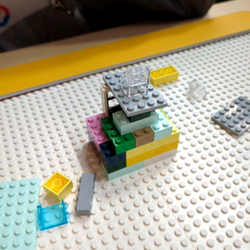

In [14]:
# Generate commentary using Gemini Flash and the defined prompt parts and configuration
commentary = gemini_flash.generate_content(
    prompt_parts, generation_config=generation_config
)

# Parse the JSON response
commentary_dict = json.loads(commentary.text)
commentary_script = commentary_dict.get("commentaryScript")
player_name_commentary_is_about = commentary_dict.get("playerNameCommentaryIsAbout")
player_number_commentary_is_about = commentary_dict.get("playerNumberCommentaryIsAbout")

# Print the extracted information
print(commentary_script)
print(player_name_commentary_is_about)
print(player_number_commentary_is_about)

# Display the image of the player being commented on
all_images[player_number_commentary_is_about - 1]

In [15]:
# Convert the commentary script to speech and play it
speak(commentary_script)

Audio content written to file output.wav


# Part 2: Contest Judging with Gemini Pro

This section demonstrates how to use Gemini Pro to judge the completed builds. Gemini Pro offers more complex and in-depth reasoning capabilities, making it ideal for evaluating the builds based on specific criteria and selecting an overall winner.

In [16]:
# Define the design challenge
design = "lighthouse"

# Define the judging prompt
judging_prompt = f"""You are judging a high-stakes toy brick building contest where
participants have only 100 seconds to construct a {design}.

 Evaluate each entry on a scale of 1-10 based on 'Creativity' & 'Execution' the following criteria:
 Creative Use of Color: Assess how intentionally and effectively different colored bricks have been used
 to enhance the overall design and convey specific themes or emotions.
 Structural Integrity: Consider the stability and durability of the build.
  Does the structure hold together under scrutiny, and does it demonstrate a sound understanding of LEGO mechanics?
  Adherence to Brief: Evaluate how closely the design aligns with the given prompt or theme.
  Does it capture the essence of the concept and avoid unnecessary deviations?
  Detail and Complexity: Assess the level of detail and complexity incorporated into the build.
  Do the smaller elements contribute to the overall aesthetic and functionality?

  And choose an overall winner!
  Output an "annoucment script" that builds up to announcing the winner. Keep it consice
  And include a "winner reasoning" that goes into specific details about why that winner was choosen. Keep it consice
  Here are the finished builds:"
  """

# Initialize the prompt parts with the judging prompt
judging_prompt_parts = [judging_prompt]

# Define the player names
player_names = ["Elara", "Finn", "Juniper", "Rhys"]

# Add player information and images to the judging prompt parts
for i, name in enumerate(player_names):
    prompt_player_part = f"Player {i+1}, {name}:"
    judging_prompt_parts.append(prompt_player_part)

    players_photo = all_images[i]
    prompt_photo_part = Part.from_image(players_photo)

    judging_prompt_parts.append(prompt_photo_part)

In [17]:
# Define the base response schema for judging
judging_response_schema_base = {
    "type": "object",
    "properties": {
        "scores": {
            "type": "object",
            "properties": {},
        },
        "overallWinner": {
            "type": "object",
            "properties": {
                "playerName": {
                    "type": "string",
                },
                "playerNumber": {
                    "type": "number",
                },
                "winnerReasoning": {
                    "type": "string",
                    "description": "specific details about why this winner was chosen.",
                },
            },
        },
        "winnerAnnouncementScript": {
            "type": "string",
            "description": "This is what the announcer will read out verbatim, comment on some specific aspects of all of the contestants builds, keeping the winner ambiguous to the very last word, e.g '... and that is why the winner is... [insert player name]!'",
        },
    },
}

# Define the response schema for individual players' scores
judging_response_schema_player = {
    "type": "object",
    "properties": {
        "playerName": {
            "type": "string",
        },
        "playerNumber": {
            "type": "number",
        },
        "score": {
            "type": "number",
            "description": "score between 1-10 for their overall build",
        },
        "scoringReasoning": {
            "type": "string",
        },
    },
}

# Add player-specific schemas to the base schema dynamically
for i, name in enumerate(player_names):
    judging_response_schema_base["properties"]["scores"]["properties"][
        f"player_{i+1}"
    ] = judging_response_schema_player

In [18]:
# Load the Gemini Pro model
gemini_pro = GenerativeModel("gemini-1.5-pro")

# Configure the generation settings for judging
generation_config = GenerationConfig(
    response_mime_type="application/json",
    response_schema=judging_response_schema_base,
    temperature=0.7,
)

In [19]:
# Generate judging results using Gemini Pro and the defined prompt parts and configuration
judging = gemini_pro.generate_content(
    judging_prompt_parts, generation_config=generation_config
)

# Parse the JSON response
judging_dict = json.loads(judging.text)

In [ ]:
# Display the judging results
judging_dict

In [21]:
# Extract information about the winner and the announcement script
winning_player_name = judging_dict["overallWinner"]["playerName"]
winning_player_number = judging_dict["overallWinner"]["playerNumber"]
winning_player_reasoning = judging_dict["overallWinner"]["winnerReasoning"]
winner_announcement_script = judging_dict["winnerAnnouncementScript"]

In [41]:
# Print and speak the winner announcement script
print(winner_announcement_script)
# speak(winner_announcement_script)

All of our contestants have crafted impressive lighthouses in just 100 seconds, demonstrating remarkable skill and creativity under pressure. Elara's vibrant design immediately catches the eye, while Finn's lighthouse stands as a beacon of classic simplicity. Juniper's build showcases a unique color palette, and Rhys's lighthouse impresses with its attention to detail and sturdy structure.  And the winner is... Rhys!


Winner is Rhys!


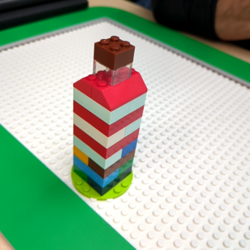

In [23]:
# Announce the winner and display their image
print(f"Winner is {winning_player_name}!")
all_images[winning_player_number - 1]

In [24]:
# Print and speak the winner reasoning
print(winning_player_reasoning)
speak(winning_player_reasoning)

Rhys's lighthouse stands out with its well-defined base, classic lighthouse shape, and creative use of color to mimic a real lighthouse. The build is solid and well-executed, demonstrating a strong understanding of the prompt.
Audio content written to file output.wav


# Part 3: Bringing the Creation to Life with Imagen

In this section, we will use Imagen to enhance the winning build by generating a dynamic and engaging background. We will then create a fun animated GIF that transitions between the original build image and the Imagen-generated image.

This showcases how Imagen can be used to create compelling visuals that complement and enhance user-generated content.

In [25]:
from vertexai.preview.vision_models import Image as Imagen_Image
from vertexai.preview.vision_models import ImageGenerationModel

In [26]:
# Load the Imagen model
imagen_model = ImageGenerationModel.from_pretrained("imagegeneration@006")

In [ ]:
# Load the winning build's image
selected_image = image_urls[winning_player_number - 1]

base_img = Imagen_Image.load_from_file(location=selected_image)
base_img.show()

In [28]:
# Define the prompt for Imagen to generate a background
image_prompt = "a macro lens photo of a toy brick lighthouse in a rocky stormy costal toy brick sea scene. The sea stretches out into the distance"

# Generate images using Imagen's edit_image function with background masking
images = imagen_model.edit_image(
    prompt=image_prompt,
    base_image=base_img,
    mask_mode="background",
    mask_dilation=0.003,  # Use a small mask dilation to avoid erasing parts of the subject
    number_of_images=3,
)

In [ ]:
# Display the generated images
for i, img in enumerate(images):
    print("generated image ", i)
    img.show()

In [34]:
# Select a favourite generated image
favourite_generated_image = 2

# Save the favourite generated image
images[favourite_generated_image].save("favourite_generated_image.png")

### Creating an Animated GIF

Now, let's create a fun GIF that fades between the original build image and the Imagen-generated image.

In [35]:
# import Pillow package for gif building
import PIL

In [36]:
# Load the start and end images for the GIF
start_image_url = image_urls[winning_player_number - 1]
end_image_url = "favourite_generated_image.png"

start_image = PIL.Image.open(start_image_url).convert("RGB")
end_image = PIL.Image.open(end_image_url).convert("RGB")

# Initialize a list to store the GIF frames
gif_frames = []

# Define the number of steps for the fade transition
gif_steps = 3

# Generate the frames for the fade-in
for i in range(gif_steps + 1):
    gif_frame = PIL.Image.blend(start_image, end_image, i / gif_steps)
    gif_frames.append(gif_frame)

# Add the end frame again so that it pauses at the generated image.
gif_frames.append(end_image)

# Add the frames for the fade-out (reverse of fade-in)
gif_frames += gif_frames[::-1]

# Save the frames as a GIF
start_image.save(
    "generated.gif",
    format="GIF",
    append_images=gif_frames,
    save_all=True,
    duration=300,
    loop=0,
)

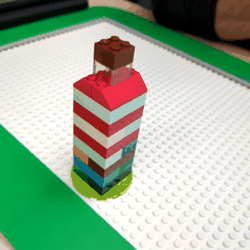

In [37]:
# Display the GIF
display.Image(filename="generated.gif")

# Conclusion

This notebook has demonstrated how to build the backend for a fun and interactive game show experience using Gemini and Imagen. We have explored various capabilities of these models, including:

* **Real-time commentary generation with Gemini Flash:** Providing immediate feedback and analysis on player builds.
* **In-depth judging and winner selection with Gemini Pro:** Leveraging advanced reasoning capabilities for a more comprehensive evaluation.
* **Enhanced visuals with Imagen:** Bringing the winning build to life with a dynamically generated background and an animated GIF.

### Potential Applications

The techniques and concepts presented in this notebook can be applied to various applications beyond game shows, such as:

* **Education:** Creating interactive learning experiences with personalized feedback and engaging visuals.
* **Content creation:** Generating dynamic content for social media, marketing campaigns, and more.
* **Entertainment:** Building interactive narratives and immersive experiences.

### Learn More

To further explore the capabilities of Gemini, Imagen, and other Generative AI technologies, check out the following resources:

* [Gemini documentation](https://cloud.google.com/vertex-ai)
* [Imagen documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview)
* [Vertex AI Generative AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/overview)
